<a href="https://colab.research.google.com/github/Teasotea/Age-Rate-Classifier-NLP/blob/main/Kaggle_dataset_other_features_dense_age_rate_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Dense Age Rate Classifier



###TODO: Build a dense neural net to classify  movies by their age rate.

In [4]:
pip install geotext


     |████████████████████████████████| 2.0 MB 7.8 MB/s 


In [5]:
! pip install kaggle

In [12]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
import os
import io
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import names
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('names')
from geotext import GeoText
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


#Old Data

In [ ]:
dataset_url = 'https://raw.githubusercontent.com/Teasotea/Age-Rate-Classifier-NLP/main/IMDB_data.csv'
df = pd.read_csv(dataset_url)
df.head()

,Unnamed: 0,Name of movie,Description,Age rate,Year,Runtime,Genre
0,0,The Shawshank Redemption,Two imprisoned men bond over a number of years...,R,1994,142,Drama
1,1,The Godfather,The Godfather follows Vito Corleone Don of the...,R,1972,175,"Crime, Drama"
2,2,Pulp Fiction,"The lives of two mob hitmen, a boxer, a gangst...",R,1994,154,"Crime, Drama"
3,3,The Godfather: Part II,The early life and career of Vito Corleone in ...,R,1974,202,"Crime, Drama"
4,4,Inception,A thief who steals corporate secrets through t...,PG-13,2010,148,"Action, Adventure, Sci-Fi"


In [ ]:
# is_r = list()
# for i in df['Age rate']:
#   if i=='R': is_r.append(1)
#   else: is_r.append(0)
# print(is_r.count(0), ":", is_r.count(1))

447 : 338


#Load data from Kaggle

In [14]:
! kaggle datasets download lukelarue/movie-attributes-for-3400-movies-from-20002020
! unzip movie-attributes-for-3400-movies-from-20002020.zip

  0% 0.00/2.11M [00:00<?, ?B/s]
100% 2.11M/2.11M [00:00<00:00, 71.2MB/s]
Archive:  movie-attributes-for-3400-movies-from-20002020.zip
  inflating: Attributes_DataFrame.csv  
  inflating: Daily_DataFrame.csv     


In [30]:
kaggle_df = pd.read_csv("Attributes_DataFrame.csv")
k_dataset = kaggle_df.drop(['Domestic','International', 'Budget'], axis=1)
k_dataset.head()

,Title,Distributor,MPAA-Rating,Runtime,Genres
0,Jurassic World (2015),Universal Pictures,PG-13,124,Action;Adventure;Sci-Fi
1,Star Wars: Episode VII - The Force Awakens (2015),Walt Disney Studios Motion Pictures,PG-13,138,Action;Adventure;Sci-Fi
2,Avengers: Age of Ultron (2015),Walt Disney Studios Motion Pictures,PG-13,141,Action;Adventure;Sci-Fi
3,Inside Out (2015),Walt Disney Studios Motion Pictures,PG,95,Adventure;Animation;Comedy;Drama;Family;Fantasy
4,Furious 7 (2015),Universal Pictures,PG-13,137,Action;Adventure;Thriller


In [31]:
is_r = list()
for i in k_dataset['MPAA-Rating']:
  if i=='R': is_r.append(1)
  else: is_r.append(0)
print(is_r.count(0), ":", is_r.count(1))

2159 : 1241


#Data processing

In [83]:
data = [n.lower() for n in k_dataset['Title']]
print(data)
for i in range(len(data)):
  data[i] += " " + str(k_dataset['Distributor'][i]).lower()
data2 = []

#define stopwords
numbers = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 	'thirteen', 'fourteen', 'fifteen', 
'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety', 'hundred']
stpwrds = stopwords.words('english') + [i.lower() for i in names.words('male.txt') + names.words('female.txt')] + numbers

#remove city names from name
for i in range(len(k_dataset['Title'])):
  places = GeoText(k_dataset['Title'][i])
  if places.cities != []:
    for j in places.cities:
      data[i] = data[i].replace(j.lower(), '')

for i in data:
  #remove punctuation and split
  tr= str.maketrans(dict.fromkeys(string.punctuation))
  new_i = i.translate(tr)
  descr = new_i.split(sep=' ')
  #remove stop words or numbers
  for k in range(5):
    for j in descr:
      if j in stpwrds or j!= '' and j[0].isdigit():
        descr.remove(j)
    if "" in descr:
      descr.remove("")
  data2.append(descr)

print(k_dataset['Title'][348], ": ",k_dataset['Distributor'][348] )
print(data[348])


['jurassic world (2015)', 'star wars: episode vii - the force awakens (2015)', 'avengers: age of ultron (2015)', 'inside out (2015)', 'furious 7 (2015)', 'american sniper (2014)', 'minions (2015)', 'the hunger games: mockingjay - part 2 (2015)', 'the martian (2015)', 'cinderella (2015)', 'how the grinch stole christmas (2000)', 'mission: impossible ii (2000)', 'gladiator (2000)', 'the perfect storm (2000)', 'meet the parents (2000)', 'x-men (2000)', 'scary movie (2000)', 'what lies beneath (2000)', 'erin brockovich (2000)', "harry potter and the sorcerer's stone (2001)", 'shrek (2001)', 'monsters, inc. (2001)', 'rush hour 2 (2001)', 'the mummy returns (2001)', 'pearl harbor (2001)', 'jurassic park iii (2001)', 'planet of the apes (2001)', 'hannibal (2001)', 'the lord of the rings: the fellowship of the ring (2001)', 'spider-man (2002)', 'star wars: episode ii - attack of the clones (2002)', 'harry potter and the chamber of secrets (2002)', 'signs (2002)', 'my big fat greek wedding (200

#Stem words

In [84]:
stemmer = PorterStemmer()
for i in range(len(data2)):
  data2[i] = [stemmer.stem(w.lower()) for w in data2[i]]
print(data2[3])

['insid', 'disney', 'studio', 'motion', 'pictur']


In [85]:
for i in range(len(data2)):
  data2[i].extend(str(k_dataset['Genres'][i]).replace(';', ' ').lower().split(' '))
  data2[i].append(str(k_dataset['Runtime'][i]))
print(data2)
short_df = pd.DataFrame(list(zip(data2, is_r)),
               columns =['info', 'age rate'])

short_df.head()
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(short_df)

[['jurass', 'world', 'univers', 'pictur', 'action', 'adventure', 'sci-fi', '124'], ['war', 'episod', 'vii', 'forc', 'awaken', 'disney', 'studio', 'motion', 'pictur', 'action', 'adventure', 'sci-fi', '138'], ['aveng', 'age', 'ultron', 'disney', 'studio', 'motion', 'pictur', 'action', 'adventure', 'sci-fi', '141'], ['insid', 'disney', 'studio', 'motion', 'pictur', 'adventure', 'animation', 'comedy', 'drama', 'family', 'fantasy', '95'], ['furiou', 'univers', 'pictur', 'action', 'adventure', 'thriller', '137'], ['american', 'sniper', 'bro', 'action', 'biography', 'drama', 'war', '133'], ['minion', 'univers', 'pictur', 'adventure', 'animation', 'comedy', 'family', 'sci-fi', '91'], ['hunger', 'game', 'mockingjay', 'part', 'lionsgat', 'action', 'adventure', 'sci-fi', 'thriller', '137'], ['martian', 'twentieth', 'centuri', 'adventure', 'drama', 'sci-fi', '144'], ['disney', 'studio', 'motion', 'pictur', 'drama', 'family', 'fantasy', 'romance', '105'], ['grinch', 'stole', 'christma', 'univers', 

,info,age rate
0,"[jurass, world, univers, pictur, action, adven...",0
1,"[war, episod, vii, forc, awaken, disney, studi...",0
2,"[aveng, age, ultron, disney, studio, motion, p...",0
3,"[insid, disney, studio, motion, pictur, advent...",0
4,"[furiou, univers, pictur, action, adventure, t...",0


# Hyperparameters


In [86]:
# output directory name:
output_dir = 'model_output/dense'

embedding_dim = 64
max_features=10000
maxlen=20

####
# training:
epochs = 6#4
batch_size = 32#784

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
#n_words_to_skip = 50 # ditto
max_decription_length = 100 #max_review_length (amount of tokens(words))
pad_type = trunc_type = 'pre' #could be 'post'

# neural network architecture: 
n_dense = 64 #neurons
dropout = 0.5 #drop 50% of neurons 





# Tokenizer

In [87]:
#tokenizer of descriptions
t  = Tokenizer(num_words=max_features)
t.fit_on_texts([x for x in short_df['info']])
print(len(t.word_index))
os.makedirs(output_dir, exist_ok=True)
with io.open(output_dir+'/tokenizer.json', 'w',encoding='utf-8', ) as f:
    f.write(json.dumps(t.to_json(),ensure_ascii=False))
vocab_size = len(t.word_index) + 1
num_categories = 1


2976


In [88]:
info_sequences = t.texts_to_sequences([x for x in np.array(short_df['info'])])
info_sequences = tf.keras.preprocessing.sequence.pad_sequences(info_sequences, maxlen=maxlen)
print(info_sequences[0])
print('sequences : ',info_sequences,'\n')
print('word_index : ',t.word_index)
print(np.array(info_sequences))

[  0   0   0   0   0   0   0   0   0   0   0   0 424 118  17   3   5   6
  11  92]
sequences :  [[  0   0   0 ...   6  11  92]
 [  0   0   0 ...   6  11 142]
 [  0   0   0 ...   6  11 150]
 ...
 [  0   0   0 ...  12   4  68]
 [  0   0   0 ...   4  29  84]
 [  0   0   0 ...   1   7  36]] 

word_index :  {'drama': 1, 'comedy': 2, 'pictur': 3, 'thriller': 4, 'action': 5, 'adventure': 6, 'romance': 7, 'crime': 8, 'fantasy': 9, 'family': 10, 'sci-fi': 11, 'mystery': 12, 'bro': 13, 'entertain': 14, 'horror': 15, 'studio': 16, 'univers': 17, 'biography': 18, 'centuri': 19, 'twentieth': 20, 'motion': 21, 'animation': 22, 'disney': 23, 'soni': 24, 'paramount': 25, 'spe': 26, 'lionsgat': 27, 'music': 28, 'war': 29, 'history': 30, 'film': 31, 'sport': 32, 'searchlight': 33, 'featur': 34, 'focu': 35, '100': 36, 'musical': 37, 'documentary': 38, '104': 39, '101': 40, '106': 41, '109': 42, '98': 43, '95': 44, '92': 45, '96': 46, '102': 47, 'new': 48, 'dreamwork': 49, '90': 50, '107': 51, 'line': 52,

#Split data into train and test 

In [89]:
X_train, X_test, y_train, y_test = train_test_split(info_sequences, short_df['age rate'], test_size=0.1, random_state=42)


print(np.array(X_train))

[[  0   0   0 ...  10  11  45]
 [  0   0   0 ...  14  38 117]
 [  0   0   0 ...   6  11  83]
 ...
 [  0   0   0 ...   1   7  92]
 [  0   0   0 ...   2   7  72]
 [  0   0   0 ...  12   4  44]]


In [90]:
l = len(X_train[363])
print(l)

20


# Model and Train

In [91]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2000,activation='relu'),
  tf.keras.layers.Dense(500,activation='relu'),
  tf.keras.layers.Dense(100,activation='relu'),
  tf.keras.layers.Dense(num_categories, activation=tf.nn.sigmoid)
])

model.compile(optimizer='nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 64)            190528    
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 2000)              2562000   
                                                                 
 dense_9 (Dense)             (None, 500)               1000500   
                                                                 
 dense_10 (Dense)            (None, 100)               50100     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,803,229
Trainable params: 3,803,229
No

In [92]:
#embedding level
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [93]:
#flatten
max_decription_length, n_dim, n_dim*max_decription_length

(100, 64, 6400)

In [94]:
#dense
n_dense, n_dim*max_decription_length*n_dense+n_dense #weights + biases

(64, 409664)

In [95]:
#output
n_dense + 1

65

#Configure model

In [96]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])


modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")
callbacks=[modelcheckpoint]



if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.fit(X_train.astype('float32'),
          np.array(y_train).astype('float32').reshape((-1,1)), 
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(X_test.astype('float32'), 
          np.array(y_test).astype('float32').reshape((-1,1))), callbacks=callbacks)

Epoch 1/6
96/96 [==============================] - 8s 70ms/step - loss: 0.5468 - accuracy: 0.6948 - val_loss: 0.5072 - val_accuracy: 0.6971
Epoch 2/6
96/96 [==============================] - 7s 70ms/step - loss: 0.4356 - accuracy: 0.7797 - val_loss: 0.4885 - val_accuracy: 0.7235
Epoch 3/6
96/96 [==============================] - 7s 69ms/step - loss: 0.2382 - accuracy: 0.9016 - val_loss: 0.6510 - val_accuracy: 0.7029
Epoch 4/6
96/96 [==============================] - 7s 69ms/step - loss: 0.0860 - accuracy: 0.9719 - val_loss: 1.0535 - val_accuracy: 0.6912
Epoch 5/6
96/96 [==============================] - 7s 68ms/step - loss: 0.0551 - accuracy: 0.9810 - val_loss: 1.0852 - val_accuracy: 0.6794
Epoch 6/6
96/96 [==============================] - 7s 69ms/step - loss: 0.0282 - accuracy: 0.9899 - val_loss: 1.2849 - val_accuracy: 0.7147


In [97]:
score = model.evaluate(np.array(X_test), np.array(y_test)) 

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

11/11 [==============================] - 0s 10ms/step - loss: 1.2849 - accuracy: 0.7147
Test Score: 1.2849384546279907
Test Accuracy: 0.7147058844566345


# Accuracy

In [98]:
model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [99]:
y_hat = model.predict(X_test)

In [100]:
len(y_hat)

340

In [101]:
y_hat[3]

array([0.30470878], dtype=float32)

In [102]:
print(np.array(y_test)[3])

0


In [103]:
print(type(y_hat))

<class 'numpy.ndarray'>


In [104]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'82.12'

In [105]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [106]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
  print(ydf)

        y_hat  y
0    0.305498  0
1    0.784516  1
2    0.840352  1
3    0.304709  0
4    0.674462  0
5    0.266689  0
6    0.651766  1
7    0.378294  0
8    0.000508  0
9    0.737447  1
10   0.054472  0
11   0.862168  1
12   0.517440  0
13   0.788363  0
14   0.242690  1
15   0.420571  0
16   0.769098  1
17   0.480419  0
18   0.392395  1
19   0.114101  0
20   0.121024  0
21   0.551152  1
22   0.258068  0
23   0.430874  1
24   0.562632  0
25   0.041589  0
26   0.659112  0
27   0.047403  0
28   0.616326  0
29   0.003006  0
30   0.091655  0
31   0.510470  1
32   0.098793  0
33   0.610910  1
34   0.392536  0
35   0.000081  0
36   0.671454  1
37   0.626930  0
38   0.000097  0
39   0.639143  1
40   0.498219  1
41   0.182238  0
42   0.237414  0
43   0.551715  1
44   0.626174  0
45   0.769274  1
46   0.000025  0
47   0.109504  0
48   0.511084  0
49   0.002543  0
50   0.816147  1
51   0.826672  1
52   0.749391  1
53   0.636252  1
54   0.005803  0
55   0.084930  0
56   0.079478  0
57   0.622803 

In [107]:
print(k_dataset.iloc[752])
print('Prediction:', y_hat[0])
print("Reality:", y_test.iloc[0])

Title                         Raising Helen (2004)
Distributor    Walt Disney Studios Motion Pictures
MPAA-Rating                                  PG-13
Runtime                                        119
Genres                        Comedy;Drama;Romance
Name: 752, dtype: object
Prediction: [0.30549783]
Reality: 0


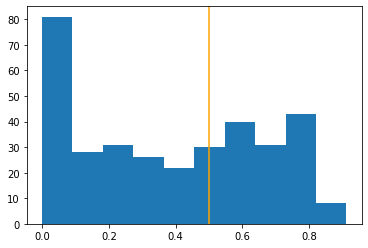

In [113]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [109]:
print(len(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)]))
print(len(y_test))

2
340


In [110]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y_test)

291     0
755     1
2096    1
432     0
479     0
1873    0
501     1
2171    0
2781    0
3093    1
1525    0
551     1
1611    0
1442    0
839     1
945     0
1135    1
2372    0
1813    1
170     0
2783    0
229     1
1775    0
798     1
2891    0
3239    0
298     0
1749    0
144     0
1612    0
32      0
2279    1
2951    0
51      1
2195    0
2819    0
1743    1
985     0
1952    0
2646    1
393     1
183     0
3235    0
3190    1
1896    0
864     1
70      0
257     0
239     0
1149    0
2771    1
2023    1
1104    1
3069    1
776     0
2515    0
810     0
1089    0
610     0
3348    0
680     1
299     0
602     1
1665    0
1132    0
1006    1
712     0
184     0
1235    1
52      0
3193    0
2723    0
1956    0
1411    0
1973    0
1614    1
1926    0
295     1
1370    0
785     0
2595    0
2377    0
2629    1
17      0
1071    1
1877    0
1582    0
315     1
2067    0
2119    0
1117    0
578     0
2355    0
2700    0
2463    0
794     0
2302    1
2661    0
818     0
2805    0


In [111]:
print(ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)])

        y_hat  y
103  0.072779  1
202  0.092329  1


In [112]:
print(ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)])
print(len(y_test))

Empty DataFrame
Columns: [y_hat, y]
Index: []
340


# Load/Save Model

In [114]:
model.save(output_dir+'/model_v005_kaggle_dataset_spwrds_removed')

INFO:tensorflow:Assets written to: model_output/dense/model_v005_kaggle_dataset_spwrds_removed/assets
